<br>**intro**

In [2]:
import sys.process._

import sys.process._

In [3]:
"pwd" !

/home/jovyan/work/notebooks


res2: Int = 0

In [4]:
"ls -l ../data/raw/" !

total 8
drwxrwxrwx  2 jovyan 1000 4096 Sep 10 09:54 test
drwxrwxrwx 50 jovyan 1000 4096 Aug 26 17:56 train


res3: Int = 0

In [5]:
val raw_data = "../data/raw/train/"
f"du -s -h $raw_data" !

2.2G	../data/raw/train/


raw_data: String = "../data/raw/train/"
res4_1: Int = 0

In [15]:
import $ivy.`org.apache.spark::spark-sql:2.4.5`
import $ivy.`org.apache.spark::spark-mllib:2.4.5`

import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)

import org.apache.spark.sql._
import org.apache.spark.sql.functions._


val spark = (
    AmmoniteSparkSession
    .builder()
    .master("local[*]")
    .getOrCreate()
)

import spark.implicits._
//Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties

Getting spark JARs
Creating SparkSession


import $ivy.$                                  

import $ivy.$                                    


import org.apache.log4j.{Level, Logger}

import org.apache.spark.sql._

import org.apache.spark.sql.functions._



spark: SparkSession = org.apache.spark.sql.SparkSession@329c73c1
import spark.implicits._
//Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties

In [11]:
// spark.catalog.clearCache()
// spark.close()
// spark.stop()

**как добавить резольвер???**

In [11]:
// resolvers += "MMLSpark" at "https://mmlspark.azureedge.net/maven"
// libraryDependencies += "com.microsoft.ml.spark" %% "mmlspark" % "1.0.0-rc3"

**легенда**

In [11]:
// instanceId_userId — идентификатор пользователя (анонимизированный);
// instanceId_objectType — тип объекта;
// instanceId_objectId — идентификатор объекта (анонимизированный);
// feedback — массив с типами реакций пользователя (наличие в массиве токена Liked говорит о том, что объект получил «класс» от пользователя);
// audit_clientType — тип платформы, с которой зашёл пользователь;
// audit_timestamp — время, когда строилась лента;
// metadata_ownerId — автор показанного объекта (анонимизированный);
// metadata_createdAt — дата создания показанного объекта.

// audit_* — расширенная информация о контексте построения ленты;
// metadata_* — расширенная информация о самом объекте;
// userOwnerCounters_* — информация о предыдущих взаимодействиях пользователя и автора контента;
// ownerUserCounters_* — информация о предыдущих взаимодействиях автора контента и пользователя;
// membership_* — информация о членстве пользователя в группе, где опубликован контент;
// user_* — подробная информация о пользователе;
// auditweights_* — большое количество runtime-признаков, извлечённых текущей системой

**загружаем источник**

In [16]:
val df = spark.read.parquet(raw_data) //.cache()

df: DataFrame = [instanceId_userId: int, instanceId_objectType: string ... 167 more fields]

<br> **work notes** <br> блок спонтанного анализа дынных - посмотреть и забыть, понять и простить

In [ ]:
// val df_join_batch = spark.read.parquet("../data/parquet/df_join_batch/")
// df_join_batch.show(1,100,true)
// df_join_batch.count()

// // странные даты

// val df_ts = df.select(($"audit_timestamp"/1000) cast "timestamp" cast "date"  as "feedback_ts", ($"metadata_createdAt"/1000)  cast "timestamp"  cast "date" as "content_ts")

// df_ts.select("feedback_ts").groupBy("feedback_ts").agg(count($"feedback_ts").alias("feedback_ts")).orderBy("feedback_ts").show(100)

// df_ts.select(
//     org.apache.spark.sql.functions.expr("date_format(content_ts, 'yyyyMM') as content_ts")
// )
// .groupBy("content_ts")
// .agg(
//     count($"content_ts").alias("content_ts")
// )
// .orderBy(desc("content_ts"))
// .show(1000)

// df_ts.unpersist()
// df.unpersist()

In [17]:
df.select("metadata_ownerId").distinct.count()

res16: Long = 81272L

In [18]:
"metadata_ownerId,user_ID_country,user_ID_Location,user_region,user_status".split(",").foreach(x => println(s"$x: ${df.select(col(x)).distinct.count().toString}"))

metadata_ownerId: 81272
user_ID_country: 212
user_ID_Location: 288701
user_region: 248
user_status: 7


In [13]:
df.select(explode($"feedback")).distinct.show()

+---------+
|      col|
+---------+
|Commented|
|   Viewed|
| ReShared|
|  Clicked|
|Complaint|
|  Ignored|
| Disliked|
|    Liked|
|  Unliked|
+---------+



In [14]:
spark.catalog.clearCache()
spark.close()
spark.stop()

<br>**ЗАДАЧА. Разобрать датасет на 2-а потока (content и feedback) и 1-ну таблицу (userinfo)**
<br>**Чтобы потом обратно собрать это все в датафрейм, но на стриме, и попытаться сделать фит-предикт тривиальным лог-регом**

In [8]:
df.printSchema

root
 |-- instanceId_userId: integer (nullable = true)
 |-- instanceId_objectType: string (nullable = true)
 |-- instanceId_objectId: integer (nullable = true)
 |-- audit_pos: long (nullable = true)
 |-- audit_clientType: string (nullable = true)
 |-- audit_timestamp: long (nullable = true)
 |-- audit_timePassed: long (nullable = true)
 |-- audit_experiment: string (nullable = true)
 |-- audit_resourceType: long (nullable = true)
 |-- metadata_ownerId: integer (nullable = true)
 |-- metadata_ownerType: string (nullable = true)
 |-- metadata_createdAt: long (nullable = true)
 |-- metadata_authorId: integer (nullable = true)
 |-- metadata_applicationId: long (nullable = true)
 |-- metadata_numCompanions: integer (nullable = true)
 |-- metadata_numPhotos: integer (nullable = true)
 |-- metadata_numPolls: integer (nullable = true)
 |-- metadata_numSymbols: integer (nullable = true)
 |-- metadata_numTokens: integer (nullable = true)
 |-- metadata_numVideos: integer (nullable = true)
 |-- me

<br>**1) Отберем часть данных для топика CONTENT (.json, topic: content)**

In [22]:
println("Statistics:\n")
// number of rows
df.select("instanceId_objectId").groupBy().agg(count('instanceId_objectId).alias("nrow")).show()
// number of unique objectId
df.select("instanceId_objectId").groupBy("instanceId_objectId").agg(count('instanceId_objectId).alias("nobj")).groupBy().agg(count('instanceId_objectId).alias("nobj")).show()

val ts    = "metadata_createdAt"
val key   = "instanceId_objectId"
val value = Array(
            "instanceId_objectType",
            "metadata_ownerId",
            "metadata_ownerType",
            "metadata_authorId",
            "metadata_applicationId",
            "metadata_numCompanions",
            "metadata_numPhotos",
            "metadata_numPolls",
            "metadata_numSymbols",
            "metadata_numTokens",
            "metadata_numVideos",
            "metadata_platform",
            "metadata_totalVideoLength",
            "metadata_options")

val renameList = value.zip(value.map(_.split("_")(1))).map(f=>{col(f._1).as(f._2)})

val df_objects = df
    .filter("""1=1
    and metadata_createdAt > 0 
    and metadata_createdAt <= audit_timestamp 
    and cast(date_format(cast((metadata_createdAt/1000) as timestamp), 'yyyyMM') as int) >= 201801
    """)
    .select((Array(col(ts), col(key))++value.map(col(_))): _*)
    .distinct

println("Before:\n")
df_objects.show(1,200,true)
df_objects.printSchema

val df_content = df_objects
    .select(col(ts).as("timestamp"), col(key).cast(types.StringType).as("key"), struct(renameList: _*) as "value")
    .filter("length(coalesce(key,-1)) > 0")
    .orderBy(col("timestamp").asc)

println("After:\n")
df_content.show(1,200,true)
df_content.printSchema

// stg 1-file json

val stg_content_test = df_content.limit(1000)
stg_content_test.coalesce(1).write.json("../data/processed/stg_content_test")
df_content.limit(10).coalesce(1).write.json("../data/processed/stg_content_example")
df_content.coalesce(1).write.json("../data/processed/stg_content")


Statistics:

+--------+
|    nrow|
+--------+
|18286575|
+--------+

+-------+
|   nobj|
+-------+
|2936576|
+-------+

Before:

-RECORD 0--------------------------------------------------------------
 metadata_createdAt        | 1519538534000                             
 instanceId_objectId       | 27670501                                  
 instanceId_objectType     | Post                                      
 metadata_ownerId          | 11873                                     
 metadata_ownerType        | GROUP_OPEN_OFFICIAL                       
 metadata_authorId         | 792913                                    
 metadata_applicationId    | 0                                         
 metadata_numCompanions    | 0                                         
 metadata_numPhotos        | 1                                         
 metadata_numPolls         | 1                                         
 metadata_numSymbols       | 0                                         
 metada

ts: String = "metadata_createdAt"
key: String = "instanceId_objectId"
value: Array[String] = Array(
  "instanceId_objectType",
  "metadata_ownerId",
  "metadata_ownerType",
  "metadata_authorId",
  "metadata_applicationId",
  "metadata_numCompanions",
  "metadata_numPhotos",
  "metadata_numPolls",
  "metadata_numSymbols",
  "metadata_numTokens",
  "metadata_numVideos",
  "metadata_platform",
  "metadata_totalVideoLength",
  "metadata_options"
)
renameList: Array[Column] = Array(
  instanceId_objectType AS `objectType`,
  metadata_ownerId AS `ownerId`,
  metadata_ownerType AS `ownerType`,
  metadata_authorId AS `authorId`,
  metadata_applicationId AS `applicationId`,
  metadata_numCompanions AS `numCompanions`,
  metadata_numPhotos AS `numPhotos`,
  metadata_numPolls AS `numPolls`,
  metadata_numSymbols AS `numSymbols`,
  metadata_numTokens AS `numTokens`,
  metadata_numVideos AS `numVideos`,
  metadata_platform AS `platform`,
  metadata_totalVideoLength AS `totalVideoLength`,
  metadat

In [6]:
val content_test = spark.read.json("../data/processed/stg_content_test/*.json")
content_test.select(date_format($"timestamp"/1000 cast "timestamp", "yyyyMM") as "ts").groupBy("ts").agg(count($"ts")).show()

+------+---------+
|    ts|count(ts)|
+------+---------+
|201801|     1000|
+------+---------+



content_test: DataFrame = [key: string, timestamp: bigint ... 1 more field]

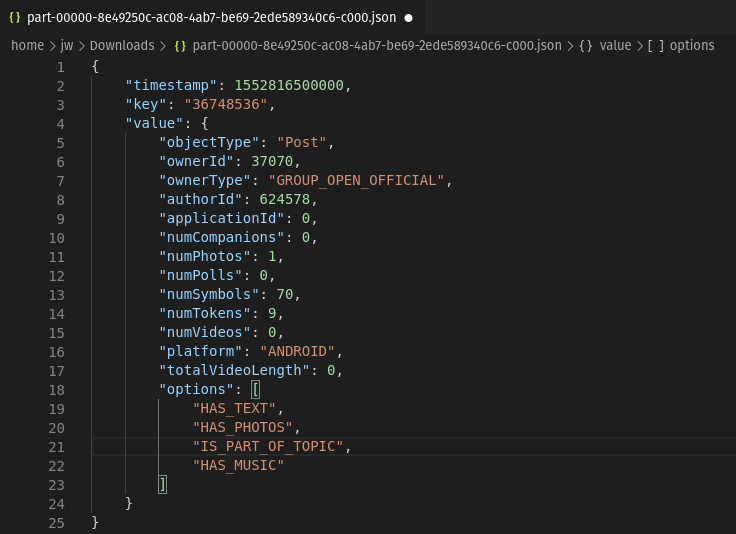

<br>**2) Отберем часть данных для топика FEEDBACK (.json)**

In [30]:
val selected_cols = Array(
    $"audit_timestamp" as "timestamp" , 
    concat_ws("_", $"instanceId_userId", $"instanceId_objectId") as "key", 
    struct(coalesce($"membership_status", lit("U")) as "membership_status", $"feedback") as "value"
)

val not_dubl = (
    df
    .filter("""1=1
    and audit_timestamp > 0 
    and instanceId_userId is not null and length(instanceId_userId) > 0
    and instanceId_objectId is not null and length(instanceId_objectId) > 0
    and metadata_createdAt > 0 
    and metadata_createdAt <= audit_timestamp 
    and cast(date_format(cast((metadata_createdAt/1000) as timestamp), 'yyyyMM') as int) >= 201801
    """) 
    .select(concat_ws("_", $"instanceId_userId", $"instanceId_objectId") as "key")
    .groupBy("key")
    .agg(count($"key").alias("cnt"))
    .filter("cnt = 1")
    .select("key")
)

val UserObjFeed = df.select(selected_cols: _*).distinct().join(not_dubl, Seq("key"), "inner").select('timestamp, 'key, 'value)

UserObjFeed.show(1,200, true)
UserObjFeed.printSchema


UserObjFeed.orderBy($"timestamp").limit(10).coalesce(1).write.json("../data/processed/stg_feedback_example")
UserObjFeed.orderBy($"timestamp").coalesce(1).write.json("../data/processed/stg_feedback")


-RECORD 0---------------------
 timestamp | 1519577908927    
 key       | 1000017_27012608 
 value     | [A, [Ignored]]   
only showing top 1 row

root
 |-- timestamp: long (nullable = true)
 |-- key: string (nullable = false)
 |-- value: struct (nullable = false)
 |    |-- membership_status: string (nullable = false)
 |    |-- feedback: array (nullable = true)
 |    |    |-- element: string (containsNull = true)



selected_cols: Array[Column] = Array(
  audit_timestamp AS `timestamp`,
  concat_ws(_, instanceId_userId, instanceId_objectId) AS `key`,
  named_struct(NamePlaceholder(), coalesce(membership_status, U) AS `membership_status`, NamePlaceholder(), feedback) AS `value`
)
not_dubl: DataFrame = [key: string]
UserObjFeed: DataFrame = [timestamp: bigint, key: string ... 1 more field]

In [48]:
(
    UserObjFeed.withColumn("key1", split($"key", "_").getItem(1))
    .join(
        stg_content_test.select("key").withColumnRenamed("key", "key1"), 
        Seq("key1"), 
        "inner"
    )
    .select($"timestamp", $"key", $"value")
    .coalesce(1)
    .write
    .json("../data/processed/stg_feedback_test")
)

In [5]:
val feedback_test = spark.read.json("../data/processed/stg_feedback_test/*.json")
feedback_test.select(date_format($"timestamp"/1000 cast "timestamp", "yyyyMM") as "ts").groupBy("ts").agg(count($"ts")).show()

+------+---------+
|    ts|count(ts)|
+------+---------+
|201801|        2|
|201802|     1715|
|201803|      671|
+------+---------+



feedback_test: DataFrame = [key: string, timestamp: bigint ... 1 more field]

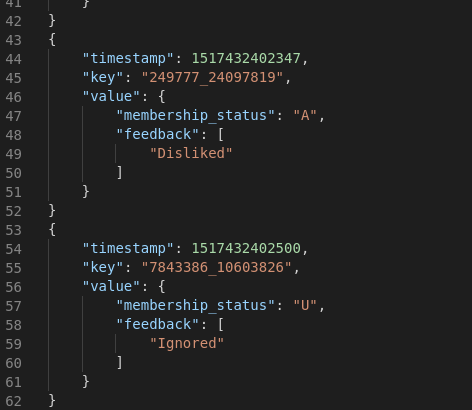

In [6]:
// df.select(explode($"feedback").alias("feedback")).groupBy("feedback").count().show()

In [6]:
// df.select("membership_status").distinct.show()

In [6]:
// UserObjFeed.select("value.membership_status").distinct.show()

<br>**3) Отберем часть данных с информацией о пользователях USERINFO - датафрейм (parquet)**

In [27]:
val user_id = Array($"instanceId_userId".as("userId"))
val user_columns = df.columns.filter(_.contains ("user_")).map(x=>col(x).as(x.replace("user_", "")))

val user_data = (
    df
    .select(user_id ++ user_columns: _*)
    .distinct
    .withColumn("change_datime", coalesce($"change_datime", $"create_date"))
    .orderBy(($"userId").asc, ($"change_datime").asc)
)
    
user_data.show(5)
user_data.groupBy().agg(count('userId).alias("nrow")).show()
user_data.limit(10).coalesce(1).write.option("header", true).csv("../data/processed/stg_userinfo_example")
user_data.coalesce(1).write.parquet("../data/processed/stg_userinfo")


+------+-------------+----------+------+------+-----------+-----------+---------+----------+---------+------------+-------------+----------------+------+
|userId|  create_date|birth_date|gender|status| ID_country|ID_Location|is_active|is_deleted|is_abused|is_activated|change_datime|is_semiactivated|region|
+------+-------------+----------+------+------+-----------+-----------+---------+----------+---------+------------+-------------+----------------+------+
|     3|1182840899490|      2216|     2|   192|10414533690|     425758|        1|         0|        0|           1|1448991398527|               0|     2|
|     6|1182841583650|     -4766|     2|   128|10414533690|    3683727|        1|         0|        0|           1|1500102484507|               0|    50|
|     9|1182841766247|      4293|     2|   192|10414533690|    3385314|        1|         0|        0|           1|1446451973670|               0|     1|
|    12|1182842289720|     -1000|     2|   192|10414533690|    3031192|     

user_id: Array[Column] = Array(instanceId_userId AS `userId`)
user_columns: Array[Column] = Array(
  user_create_date AS `create_date`,
  user_birth_date AS `birth_date`,
  user_gender AS `gender`,
  user_status AS `status`,
  user_ID_country AS `ID_country`,
  user_ID_Location AS `ID_Location`,
  user_is_active AS `is_active`,
  user_is_deleted AS `is_deleted`,
  user_is_abused AS `is_abused`,
  user_is_activated AS `is_activated`,
  user_change_datime AS `change_datime`,
  user_is_semiactivated AS `is_semiactivated`,
  user_region AS `region`
)
user_data: Dataset[Row] = [userId: int, create_date: bigint ... 12 more fields]

In [33]:
val userinfo = spark.read.parquet("../data/processed/stg_userinfo/")
userinfo.printSchema

root
 |-- userId: integer (nullable = true)
 |-- create_date: long (nullable = true)
 |-- birth_date: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- status: integer (nullable = true)
 |-- ID_country: long (nullable = true)
 |-- ID_Location: integer (nullable = true)
 |-- is_active: integer (nullable = true)
 |-- is_deleted: integer (nullable = true)
 |-- is_abused: integer (nullable = true)
 |-- is_activated: integer (nullable = true)
 |-- change_datime: long (nullable = true)
 |-- is_semiactivated: integer (nullable = true)
 |-- region: integer (nullable = true)



userinfo: DataFrame = [userId: int, create_date: bigint ... 12 more fields]

**Тестируем процессинг на статичных файлах**

In [92]:
val feedback_test = spark.read.json("../data/processed/stg_feedback_test/*.json")

feedback_test: DataFrame = [key: string, timestamp: bigint ... 1 more field]

In [53]:
feedback_test.groupBy("key").count().filter("count > 1") show()

+-----------------+-----+
|              key|count|
+-----------------+-----+
| 6336744_18571840|    2|
| 5538045_18571840|    2|
| 7808703_18571840|    2|
|13776732_18571840|    2|
| 1042290_18571840|    2|
|12595017_18571840|    2|
|15544770_18571840|    2|
|11055765_18571840|    2|
|10330464_18571840|    2|
| 4956369_18571840|    2|
|13399518_18571840|    2|
|  853677_18571840|    2|
| 7576560_18571840|    2|
|  182058_18571840|    2|
| 4734804_18571840|    2|
| 8916486_18571840|    2|
| 8992035_18571840|    2|
| 2902149_18571840|    2|
| 4579161_18571840|    2|
|  104571_18571840|    2|
+-----------------+-----+



In [110]:

val feedback_test1 = feedback_test
.select(
    split($"key", "_").getItem(0) as "feedback_useID", 
    split($"key", "_").getItem(1) as "feedback_objID", 
    $"timestamp"/1000 cast "timestamp" as "ts1", 
    $"value"("feedback") as "feedback"
)

feedback_test1.show(10)
feedback_test1.count()

+--------------+--------------+--------------------+--------------------+
|feedback_useID|feedback_objID|                 ts1|            feedback|
+--------------+--------------+--------------------+--------------------+
|      10486914|        304539|2018-02-18 11:57:...|           [Clicked]|
|      11248422|      14838919|2018-02-24 15:09:...|           [Ignored]|
|      11972100|      22599605|2018-02-06 17:26:...|           [Ignored]|
|      14952438|      12465334|2018-03-03 13:17:...|             [Liked]|
|      15279759|        304539|2018-03-13 02:46:...|           [Ignored]|
|       2252610|        304539|2018-02-17 18:29:...|           [Ignored]|
|       2780709|      11322902|2018-02-21 15:59:...|           [Ignored]|
|        305451|        290443|2018-02-06 22:11:...|           [Ignored]|
|       3137910|      16196712|2018-02-03 07:56:...|[Clicked, Liked, ...|
|       3169221|      12681913|2018-02-15 00:39:...|           [Ignored]|
+--------------+--------------+-------

feedback_test1: DataFrame = [feedback_useID: string, feedback_objID: string ... 2 more fields]
res109_2: Long = 2388L

In [111]:
val content_test = spark.read.json("../data/processed/stg_content_test/*.json")

val content_test1 = content_test.select(
    $"key" as "content_objID", 
    $"timestamp" /1000 cast "timestamp"  as "ts2", 
    $"value.*")

content_test1.show(5,10)

+-------------+----------+-------------+--------+-------------+---------+--------+----------+---------+---------+----------+----------+-------+----------+--------+----------------+
|content_objID|       ts2|applicationId|authorId|numCompanions|numPhotos|numPolls|numSymbols|numTokens|numVideos|objectType|   options|ownerId| ownerType|platform|totalVideoLength|
+-------------+----------+-------------+--------+-------------+---------+--------+----------+---------+---------+----------+----------+-------+----------+--------+----------------+
|     16876204|2018-01...|            0|  680017|            0|        1|       0|         0|        0|        0|      Post|[HAS_PH...|  31419|GROUP_O...|   OTHER|               0|
|       289803|2018-01...|            0|  905556|            0|        0|       0|        32|        2|        0|     Video|[HAS_TE...|  14174|GROUP_OPEN| ANDROID|           60024|
|     18216307|2018-01...|            0|  678857|            0|        1|       0|        43|  

content_test: DataFrame = [key: string, timestamp: bigint ... 1 more field]
content_test1: DataFrame = [content_objID: string, ts2: timestamp ... 14 more fields]

In [112]:
content_test1.groupBy("content_objID").count().filter("count > 1").show()

+-------------+-----+
|content_objID|count|
+-------------+-----+
|     18571840|    2|
+-------------+-----+



In [113]:
content_test1.filter("content_objID = 18571840").show()

+-------------+-------------------+-------------+--------+-------------+---------+--------+----------+---------+---------+----------+--------------------+-------+-------------------+--------+----------------+
|content_objID|                ts2|applicationId|authorId|numCompanions|numPhotos|numPolls|numSymbols|numTokens|numVideos|objectType|             options|ownerId|          ownerType|platform|totalVideoLength|
+-------------+-------------------+-------------+--------+-------------+---------+--------+----------+---------+---------+----------+--------------------+-------+-------------------+--------+----------------+
|     18571840|2018-01-02 15:02:27|            0|  726145|            0|        1|       0|       462|       56|        0|      Post|[HAS_TEXT, HAS_PH...|  40134|GROUP_OPEN_OFFICIAL|     WEB|               0|
|     18571840|2018-01-02 15:02:27|            0|  726145|            0|        2|       0|       462|       56|        0|      Post|[HAS_TEXT, HAS_PH...|  40134|GR

In [114]:
feedback_test1.filter("feedback_objID = 18571840").show()

+--------------+--------------+--------------------+--------------------+
|feedback_useID|feedback_objID|                 ts1|            feedback|
+--------------+--------------+--------------------+--------------------+
|       6336744|      18571840|2018-02-09 12:33:...|           [Clicked]|
|       6336744|      18571840|2018-02-09 12:33:...|           [Clicked]|
|       5538045|      18571840|2018-02-10 19:56:...|          [Disliked]|
|       5538045|      18571840|2018-02-10 19:56:...|          [Disliked]|
|       7808703|      18571840|2018-03-05 04:37:...|           [Ignored]|
|       7808703|      18571840|2018-03-05 04:37:...|           [Ignored]|
|      13776732|      18571840|2018-02-10 11:33:...|           [Ignored]|
|      13776732|      18571840|2018-02-10 11:33:...|           [Ignored]|
|       1042290|      18571840|2018-02-23 07:12:...|           [Ignored]|
|       1042290|      18571840|2018-02-23 07:12:...|           [Ignored]|
|      12595017|      18571840|2018-03

In [115]:
val df_join = 
feedback_test1.withColumn("target", array_contains($"feedback", "Liked") cast "int")
.join(
content_test1.select("content_objID","ts2","objectType","options"), 
expr("feedback_objID == content_objID"), "left"
)
.join(
userinfo.withColumnRenamed("userId", "useID").select("useID","birth_date", "gender"),
expr("feedback_useID == useID"), "left"
).withColumn("daysDiff", datediff($"ts1",$"ts2"))

df_join.show(10)
df_join.count()

+--------------+--------------+--------------------+-----------------+------+-------------+-------------------+----------+--------------------+--------+----------+------+--------+
|feedback_useID|feedback_objID|                 ts1|         feedback|target|content_objID|                ts2|objectType|             options|   useID|birth_date|gender|daysDiff|
+--------------+--------------+--------------------+-----------------+------+-------------+-------------------+----------+--------------------+--------+----------+------+--------+
|        441201|      18664504|2018-02-10 13:42:...|          [Liked]|     1|     18664504|2018-01-01 21:15:15|      Post|[HAS_TEXT, HAS_PH...|  441201|     -1670|     2|      40|
|        799119|      14946639|2018-02-04 22:26:...|        [Ignored]|     0|     14946639|2018-01-01 16:06:12|      Post|[HAS_PHOTOS, IS_P...|  799119|      4981|     2|      34|
|       2125926|      16233042|2018-03-06 15:11:...|        [Clicked]|     0|     16233042|2018-01-0

df_join: DataFrame = [feedback_useID: string, feedback_objID: string ... 11 more fields]
res114_2: Long = 2878L

In [116]:
(
    df_join
    .select("feedback_useID","feedback_objID")
    .withColumn("feedback_ID", concat_ws("_", $"feedback_useID", $"feedback_objID"))
    .groupBy("feedback_ID")
    .count()
    .filter("count > 1")
    .count()
)

res115: Long = 392L

In [117]:
val df_join1 = 
feedback_test1.withColumn("target", array_contains($"feedback", "Liked") cast "int")
.join(
    right = content_test1.select("content_objID", "ts2", "objectType", "options"), 
    joinExprs = 
        feedback_test1("feedback_objID") === content_test1("content_objID") && 
        feedback_test1("ts1").geq(content_test1("ts2")) && 
        feedback_test1("ts1").leq(content_test1("ts2") + expr("interval 3 months")), 
    joinType = "left"
).filter("content_objID is not null")

df_join1: Dataset[Row] = [feedback_useID: string, feedback_objID: string ... 7 more fields]

In [118]:
df_join1.printSchema

root
 |-- feedback_useID: string (nullable = true)
 |-- feedback_objID: string (nullable = true)
 |-- ts1: timestamp (nullable = true)
 |-- feedback: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- target: integer (nullable = true)
 |-- content_objID: string (nullable = true)
 |-- ts2: timestamp (nullable = true)
 |-- objectType: string (nullable = true)
 |-- options: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [119]:
df_join1.show(5)

+--------------+--------------+--------------------+---------+------+-------------+-------------------+----------+--------------------+
|feedback_useID|feedback_objID|                 ts1| feedback|target|content_objID|                ts2|objectType|             options|
+--------------+--------------+--------------------+---------+------+-------------+-------------------+----------+--------------------+
|      10486914|        304539|2018-02-18 11:57:...|[Clicked]|     0|       304539|2018-01-01 13:40:34|     Video|[HAS_TEXT, HAS_VI...|
|      11248422|      14838919|2018-02-24 15:09:...|[Ignored]|     0|     14838919|2018-01-02 14:55:06|      Post|[HAS_TEXT, HAS_PH...|
|      11972100|      22599605|2018-02-06 17:26:...|[Ignored]|     0|     22599605|2018-01-02 07:00:22|      Post|[HAS_TEXT, HAS_PH...|
|      14952438|      12465334|2018-03-03 13:17:...|  [Liked]|     1|     12465334|2018-01-01 19:01:35|      Post|[HAS_PHOTOS, IS_P...|
|      15279759|        304539|2018-03-13 02:46:

In [120]:
df_join1.count()

res119: Long = 2428L

In [121]:
feedback_test1("ts1").geq(content_test1("ts2")) && feedback_test1("ts1").leq(content_test1("ts2") + expr("interval 1 months"))

res120: Column = ((ts1 >= ts2) AND (ts1 <= (ts2 + interval 1 months)))

In [122]:
expr("interval 1 months")

res121: Column = interval 1 months

In [123]:
feedback_test1.select($"ts1", $"ts1" + expr("interval 1 months") as "ts1_int").show()

+--------------------+--------------------+
|                 ts1|             ts1_int|
+--------------------+--------------------+
|2018-02-18 11:57:...|2018-03-18 11:57:...|
|2018-02-24 15:09:...|2018-03-24 15:09:...|
|2018-02-06 17:26:...|2018-03-06 17:26:...|
|2018-03-03 13:17:...|2018-04-03 13:17:...|
|2018-03-13 02:46:...|2018-04-13 02:46:...|
|2018-02-17 18:29:...|2018-03-17 18:29:...|
|2018-02-21 15:59:...|2018-03-21 15:59:...|
|2018-02-06 22:11:...|2018-03-06 22:11:...|
|2018-02-03 07:56:...|2018-03-03 07:56:...|
|2018-02-15 00:39:...|2018-03-15 00:39:...|
|2018-03-10 04:16:...|2018-04-10 04:16:...|
|2018-02-04 12:57:...|2018-03-04 12:57:...|
|2018-02-13 20:51:...|2018-03-13 20:51:...|
|2018-03-08 15:47:...|2018-04-08 15:47:...|
|2018-03-04 05:01:...|2018-04-04 05:01:...|
|2018-02-23 19:19:...|2018-03-23 19:19:...|
|2018-02-07 18:38:...|2018-03-07 18:38:...|
|2018-03-21 13:37:...|2018-04-21 13:37:...|
|2018-02-05 18:32:...|2018-03-05 18:32:...|
|2018-02-22 11:00:...|2018-03-22

In [124]:
df_join.filter("feedback_useID = '3967689' and feedback_objID = '9853823'").show(1,100,true)

-RECORD 0--------------------------------------------------
 feedback_useID | 3967689                                  
 feedback_objID | 9853823                                  
 ts1            | 2018-02-12 10:40:58.933                  
 feedback       | [Ignored]                                
 target         | 0                                        
 content_objID  | 9853823                                  
 ts2            | 2018-01-01 09:50:18                      
 objectType     | Post                                     
 options        | [HAS_TEXT, HAS_PHOTOS, IS_PART_OF_TOPIC] 
 useID          | 3967689                                  
 birth_date     | 4536                                     
 gender         | 2                                        
 daysDiff       | 42                                       



In [47]:
df_ts.unpersist()
df.unpersist()

cmd47.sc:1: not found: value df_ts
val res47_0 = df_ts.unpersist()
              ^cmd47.sc:2: not found: value df
val res47_1 = df.unpersist()
              ^Compilation Failed

: 

In [48]:
spark.catalog.clearCache()
spark.close()
spark.stop()

In [53]:
f"du -s -h ../data/processed/" !

2.9G	../data/processed/


res52: Int = 0

In [18]:
"pwd" !

/home/jovyan/work/notebooks


res17: Int = 0

In [24]:
f"du -h ../data/processed" !

16K	../data/processed/stg_content_example
1.9G	../data/processed/stg_feedback
946M	../data/processed/stg_content
16K	../data/processed/stg_feedback_example
272K	../data/processed/stg_feedback_test
8.0K	../data/processed/stg_userinfo_example/.ipynb_checkpoints
24K	../data/processed/stg_userinfo_example
4.0K	../data/processed/stg_userinfo/.ipynb_checkpoints
87M	../data/processed/stg_userinfo
352K	../data/processed/stg_content_test
8.0K	../data/processed/.ipynb_checkpoints
2.9G	../data/processed


res23: Int = 0

<br>**Тестируем процессинг**

In [ ]:
import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.types._

import org.apache.spark.ml.feature.{HashingTF, IDF, Tokenizer, VectorAssembler}

val stringStack = concat_ws(" ", 
                            concat(lit("sex_"), $"user_gender".cast(StringType)),
                            concat(lit("status_"), $"user_status".cast(StringType)),
                            concat(lit("country_"),$"user_ID_country".cast(StringType)),
                            concat(lit("location_"), $"user_ID_Location".cast(StringType)),
                            concat(lit("region_"), $"user_region".cast(StringType)),
                            when($"user_is_active" === 1, "is_active"),
                            when($"user_is_deleted" === 1, "is_deleted"),
                            when($"user_is_abused" === 1, "is_abused"),
                            when($"user_is_activated" === 1, "is_activated"),
                            concat(lit("ustatus_"), coalesce(lower($"membership_status"), lit("none"))), 
                            lower($"instanceId_objectType"), 
                            lower(concat_ws(" ", $"metadata_options")), 
                            lower($"metadata_ownerType"), 
                            lower($"metadata_platform")
                           )

df.withColumn("stringStack", stringStack).select("stringStack").show(3,200,true)

val tokenizer = (new Tokenizer()
                 .setInputCol("stringStack")
                 .setOutputCol("tokens")
                )

val tokensData = (
    tokenizer
    .transform(
        df
        .withColumn("stringStack", stringStack)
        .select("metadata_numCompanions",
                "metadata_numPhotos",
                "metadata_numPolls",
                "metadata_numSymbols",
                "metadata_numTokens",
                "metadata_numVideos",
                "stringStack")
    )
)

val hashingTF = (new HashingTF()
                 .setInputCol("tokens")
                 .setOutputCol("rawFeatures")
                 .setNumFeatures(10000)
                )

val featurizedData = (hashingTF
                      .transform(tokensData)
                     )

val idf = (new IDF()
           .setInputCol("rawFeatures")
           .setOutputCol("features_tfidf")
          )

val idfModel = idf.fit(featurizedData)

val tfidfData = idfModel.transform(featurizedData)

val assembler = (new VectorAssembler()
                 .setInputCols(Array("features_tfidf", 
                                     "metadata_numCompanions",
                                     "metadata_numPhotos",
                                     "metadata_numPolls",
                                     "metadata_numSymbols",
                                     "metadata_numTokens",
                                     "metadata_numVideos"))
                 .setOutputCol("features")
                )

val assembled = assembler.transform(tfidfData)

assembled.show(10,10)

In [ ]:
// sudo docker exec -it almond /bin/bash
// "mv stg_content/part*.json content.json" !
// "rm -rf ../data/processed/stg_content" !

// "mv stg_userobject/part*.json userobject.json" !
// "rm -rf ../data/processed/stg_userobject" !

// "mv stg_stg_userinfo/part*.parquet userinfo.parquet" !
// "rm -rf ../data/processed/stg_parquet" !